In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import string
import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("punkt")
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rahul\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("../data/raw/blogtext.csv")

In [3]:
pd.set_option("display.max_colwidth", 100)
df.head()

,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages, and 4.5 MB of .pdf files) Now i have to wait unti..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewes van der Laag urlLink mail Ruiyu Xie ...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde: MAAK JE EIGEN WATERSTOFBOM How to build an H-...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can now 'capture' the URLs of popups...which means now...


In [4]:
df = df.sample(n=50000, random_state=42)

In [5]:
df.dropna()

,id,gender,age,topic,sign,date,text
240436,1058543,female,24,indUnk,Sagittarius,"02,August,2004",1 Corinthians 5:11 'But now I have written to you not to keep company with anyone named ...
54139,3440336,female,23,Arts,Virgo,"08,July,2004","Having moved to Jersey City nearly a month ago, I had no idea that I would be packing up ..."
637911,3546243,female,24,indUnk,Taurus,"02,July,2004","urlLink Hey, Metro! Need To Save Money? Take a Hike. And this comes on the heels..."
61178,3367064,female,26,indUnk,Taurus,"29,July,2004",The most hilarious movie I have seen this year.. a comedy movie with absolutely no ...
314089,3590478,female,34,Technology,Capricorn,"20,April,2004",Short of being attached to the bumper of a pickup truck by a cock ring and being d...
...,...,...,...,...,...,...,...
489324,2793554,female,16,Student,Aries,"13,June,2004",mood: rebellious music: look back and laugh- minor threat my aunt is a bitch. she...
373999,3704850,male,26,Education,Pisces,"30,July,2004",We need a mechanism that safeguards against uploading a new file of the same name a...
562002,1157144,female,17,Student,Libra,"05,August,2004","oh yes, to see, not to do.... right. well speaking of things to do, i mean see... who can..."
80072,3878046,female,23,Student,Aquarius,"09,December,2003",I live in a dream cos the dream never happens in real life. 'It hurt like a rusty spear ...


In [6]:
df.shape

(50000, 7)

In [7]:
df.isnull().sum()

id        0
gender    0
age       0
topic     0
sign      0
date      0
text      0
dtype: int64

In [8]:
df.isna().any()

id        False
gender    False
age       False
topic     False
sign      False
date      False
text      False
dtype: bool

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,50000.0,2.396383e+06,1.247076e+06,5114.0,1237310.0,2607577.0,3527980.25,4336871.0
age,50000.0,2.385672e+01,7.735313e+00,13.0,17.0,24.0,26.00,48.0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 240436 to 389094
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      50000 non-null  int64 
 1   gender  50000 non-null  object
 2   age     50000 non-null  int64 
 3   topic   50000 non-null  object
 4   sign    50000 non-null  object
 5   date    50000 non-null  object
 6   text    50000 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.1+ MB


In [11]:
df.columns

Index(['id', 'gender', 'age', 'topic', 'sign', 'date', 'text'], dtype='object')

In [12]:
# Creating a new dataframe with two columns
df = df[["topic", "text"]]

In [13]:
df["topic"].value_counts()

topic
indUnk                     18419
Student                    11519
Technology                  2985
Arts                        2339
Education                   2219
Communications-Media        1458
Internet                    1197
Non-Profit                  1027
Engineering                  855
Law                          684
Publishing                   550
Science                      550
Government                   496
Consulting                   388
Marketing                    371
Religion                     370
Fashion                      360
BusinessServices             339
Advertising                  330
Chemicals                    325
Banking                      274
Telecommunications           269
Accounting                   264
Sports-Recreation            240
RealEstate                   227
Military                     222
HumanResources               219
Museums-Libraries            208
Transportation               176
Manufacturing                172
Biot

In [14]:
options = ["Law", "Science", "Religion", "Fashion", "Banking", "Chemicals", "Telecommunications"]
df = df.loc[df["topic"].isin(options)]
df

,topic,text
199219,Law,"urlLink State Rep. Derrick Shepherd, D-Marrero of Louisiana has drafted a bill would ban..."
206493,Law,Estava conversando esta manha com uma amiga e essa frase veio em nossa conversacao. Lembr...
667662,Law,My Family and Jesse James I am the family's resident genealogist. I am aware of how many tim...
182930,Science,Going to visit my grandmother today. Also going to hit a ton of traffic on the...
608069,Religion,"recently, i had someone ask me if i always had turned to God (in terms of over ..."
...,...,...
558338,Religion,Heya First day of the exams today and of course in my typical style im once again findin...
573017,Banking,i walked down the Sunny Side of the road on my way to work today. there's nothing quite l...
493512,Law,"...Sadly, there is not much to post Friday: Attend the 'Badin Breakdown'--A kareoke..."
306550,Religion,Now with comments.. The title really says it all - now go away.


In [15]:
df["topic"].value_counts()

topic
Law                   684
Science               550
Religion              370
Fashion               360
Chemicals             325
Banking               274
Telecommunications    269
Name: count, dtype: int64

In [16]:
df["topic_id"] = df["topic"].factorize()[0]

topic_id_df = df[["topic", "topic_id"]].drop_duplicates().sort_values("topic_id")

topic_to_id = dict(topic_id_df.values)
id_to_topic = dict(topic_id_df[["topic_id", "topic"]].values)

In [17]:
df.head()

,topic,text,topic_id
199219,Law,"urlLink State Rep. Derrick Shepherd, D-Marrero of Louisiana has drafted a bill would ban...",0
206493,Law,Estava conversando esta manha com uma amiga e essa frase veio em nossa conversacao. Lembr...,0
667662,Law,My Family and Jesse James I am the family's resident genealogist. I am aware of how many tim...,0
182930,Science,Going to visit my grandmother today. Also going to hit a ton of traffic on the...,1
608069,Religion,"recently, i had someone ask me if i always had turned to God (in terms of over ...",2


In [18]:
df["topic_id"].value_counts()

topic_id
0    684
1    550
2    370
5    360
4    325
3    274
6    269
Name: count, dtype: int64

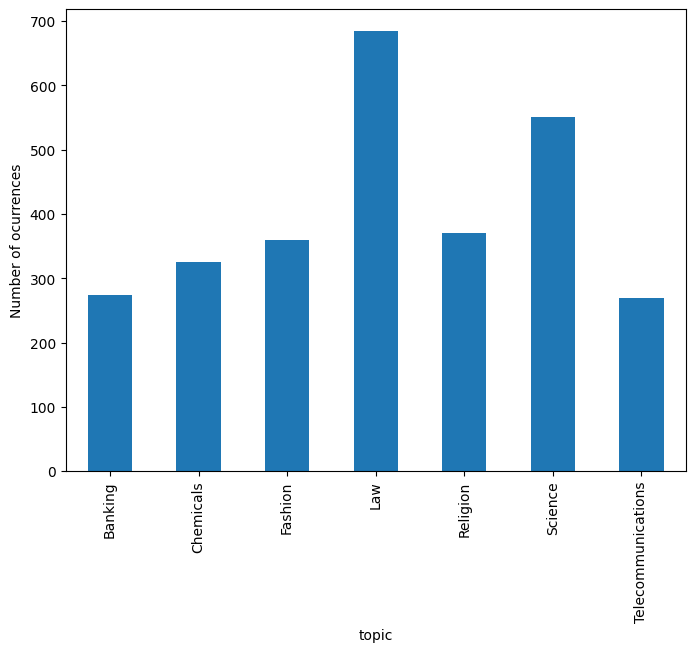

In [19]:
# Visualize the data

fig = plt.figure(figsize=(8,6))
df.groupby('topic').text.count().plot.bar(ylim=0)
plt.ylabel("Number of ocurrences", fontsize = 10);
plt.show()

In [20]:
df.head()

,topic,text,topic_id
199219,Law,"urlLink State Rep. Derrick Shepherd, D-Marrero of Louisiana has drafted a bill would ban...",0
206493,Law,Estava conversando esta manha com uma amiga e essa frase veio em nossa conversacao. Lembr...,0
667662,Law,My Family and Jesse James I am the family's resident genealogist. I am aware of how many tim...,0
182930,Science,Going to visit my grandmother today. Also going to hit a ton of traffic on the...,1
608069,Religion,"recently, i had someone ask me if i always had turned to God (in terms of over ...",2


In [21]:
# Pre-processing the "text" column
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
# removing punctuation

def remove_punctuation(text):
    text = "".join([c for c in text if c not in string.punctuation])
    return text

df["text"] = df["text"].apply(lambda x: remove_punctuation(x))
df.head()

,topic,text,topic_id
199219,Law,urlLink State Rep Derrick Shepherd DMarrero of Louisiana has drafted a bill would ban pa...,0
206493,Law,Estava conversando esta manha com uma amiga e essa frase veio em nossa conversacao Lembra...,0
667662,Law,My Family and Jesse James I am the familys resident genealogist I am aware of how many times...,0
182930,Science,Going to visit my grandmother today Also going to hit a ton of traffic on the ...,1
608069,Religion,recently i had someone ask me if i always had turned to God in terms of over ti...,2


In [23]:
# removing unwanted characters
df["text"] = df["text"].apply(lambda x: re.sub('[^A-Za-z0-9]+', " ", x))
df.head()

,topic,text,topic_id
199219,Law,urlLink State Rep Derrick Shepherd DMarrero of Louisiana has drafted a bill would ban pants wor...,0
206493,Law,Estava conversando esta manha com uma amiga e essa frase veio em nossa conversacao Lembravamos ...,0
667662,Law,My Family and Jesse James I am the familys resident genealogist I am aware of how many times I ...,0
182930,Science,Going to visit my grandmother today Also going to hit a ton of traffic on the way Tomorrow is f...,1
608069,Religion,recently i had someone ask me if i always had turned to God in terms of over time well the answ...,2


In [24]:
# removing whitespaces (begining and trailing spaces)
df["text"] = df["text"].apply(lambda x: x.strip())
df.head()

,topic,text,topic_id
199219,Law,urlLink State Rep Derrick Shepherd DMarrero of Louisiana has drafted a bill would ban pants worn...,0
206493,Law,Estava conversando esta manha com uma amiga e essa frase veio em nossa conversacao Lembravamos d...,0
667662,Law,My Family and Jesse James I am the familys resident genealogist I am aware of how many times I a...,0
182930,Science,Going to visit my grandmother today Also going to hit a ton of traffic on the way Tomorrow is fa...,1
608069,Religion,recently i had someone ask me if i always had turned to God in terms of over time well the answe...,2


In [25]:
# replacing more than 1 spaces with single space
df["text"] = df["text"].str.replace(r"\s\s+", " ")
df.head()

,topic,text,topic_id
199219,Law,urlLink State Rep Derrick Shepherd DMarrero of Louisiana has drafted a bill would ban pants worn...,0
206493,Law,Estava conversando esta manha com uma amiga e essa frase veio em nossa conversacao Lembravamos d...,0
667662,Law,My Family and Jesse James I am the familys resident genealogist I am aware of how many times I a...,0
182930,Science,Going to visit my grandmother today Also going to hit a ton of traffic on the way Tomorrow is fa...,1
608069,Religion,recently i had someone ask me if i always had turned to God in terms of over time well the answe...,2


In [26]:
# tokenization
def tokenize(text):
    tokens = re.split("\W+", text)
    return tokens

df["text"] = df["text"].apply(lambda x: tokenize(x.lower()))
df.head()

,topic,text,topic_id
199219,Law,"[urllink, state, rep, derrick, shepherd, dmarrero, of, louisiana, has, drafted, a, bill, would, ...",0
206493,Law,"[estava, conversando, esta, manha, com, uma, amiga, e, essa, frase, veio, em, nossa, conversacao...",0
667662,Law,"[my, family, and, jesse, james, i, am, the, familys, resident, genealogist, i, am, aware, of, ho...",0
182930,Science,"[going, to, visit, my, grandmother, today, also, going, to, hit, a, ton, of, traffic, on, the, w...",1
608069,Religion,"[recently, i, had, someone, ask, me, if, i, always, had, turned, to, god, in, terms, of, over, t...",2


In [27]:
# removing stopwords

stopwords = nltk.corpus.stopwords.words("english")
stopwords.append("urllink")
stopwords[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [28]:
def remove_stopwords(text):
    text = [word for word in text if word not in stopwords]
    return text

df["text"] = df["text"].apply(lambda x: remove_stopwords(x))
df.head()

,topic,text,topic_id
199219,Law,"[state, rep, derrick, shepherd, dmarrero, louisiana, drafted, bill, would, ban, pants, worn, low...",0
206493,Law,"[estava, conversando, esta, manha, com, uma, amiga, e, essa, frase, veio, em, nossa, conversacao...",0
667662,Law,"[family, jesse, james, familys, resident, genealogist, aware, many, times, cousin, big, deal, ro...",0
182930,Science,"[going, visit, grandmother, today, also, going, hit, ton, traffic, way, tomorrow, fathers, day, ...",1
608069,Religion,"[recently, someone, ask, always, turned, god, terms, time, well, answer, isnt, simple, always, k...",2


In [29]:
# lemmatization

wn = nltk.WordNetLemmatizer()

def lemmatization(text):
    text = [wn.lemmatize(word) for word in text]
    return " ".join(text)

df["text"] = df["text"].apply(lambda x: lemmatization(x))
df.head()

,topic,text,topic_id
199219,Law,state rep derrick shepherd dmarrero louisiana drafted bill would ban pant worn low said filed bi...,0
206493,Law,estava conversando esta manha com uma amiga e essa frase veio em nossa conversacao lembravamos d...,0
667662,Law,family jesse james family resident genealogist aware many time cousin big deal royal oh well app...,0
182930,Science,going visit grandmother today also going hit ton traffic way tomorrow father day happy father da...,1
608069,Religion,recently someone ask always turned god term time well answer isnt simple always knew god brought...,2


In [30]:
# Further Text processing using TF-IDF

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,2), stop_words="english")

# Transforming each text into a vector
features = tfidf.fit_transform(df.text).toarray()
labels = df.topic_id
print(features.shape)

(2832, 6871)


In [31]:
tfidf.vocabulary_

{'state': 5734,
 'rep': 5043,
 'ban': 528,
 'pant': 4340,
 'worn': 6774,
 'low': 3705,
 'said': 5233,
 'filed': 2198,
 'tired': 6224,
 'catching': 902,
 'glimpse': 2468,
 'short': 5462,
 'belt': 604,
 'line': 3583,
 'young': 6850,
 'adult': 212,
 'caught': 905,
 'wearing': 6633,
 'fine': 2212,
 '500': 96,
 'month': 3975,
 'jail': 3200,
 'sick': 5481,
 'seeing': 5363,
 'community': 1153,
 'parent': 4350,
 'job': 3234,
 'child': 988,
 'wear': 6632,
 'law': 3435,
 'say': 5280,
 'bikini': 639,
 'clothing': 1076,
 'summer': 5871,
 'approaching': 373,
 'com': 1111,
 'uma': 6386,
 'em': 1891,
 'um': 6385,
 'que': 4820,
 'eu': 1990,
 'para': 4345,
 'la': 3391,
 'na': 4032,
 'bar': 534,
 'era': 1970,
 'point': 4558,
 'cool': 1281,
 'legal': 3475,
 'simple': 5501,
 'family': 2113,
 'james': 3202,
 'resident': 5078,
 'aware': 490,
 'time': 6174,
 'cousin': 1325,
 'big': 630,
 'deal': 1491,
 'royal': 5198,
 'oh': 4212,
 'certain': 929,
 'dont': 1725,
 'eye': 2071,
 'middle': 3908,
 'forehead': 228

In [32]:
# Finding the two most correlated terms with each of the sign categories
N = 2
for topic, topic_id in sorted(topic_to_id.items()):
    features_chi2 = chi2(features, labels == topic_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names_out())[indices]
    unigrams = [v for v in feature_names if len(v.split(" ")) == 1]
    bigrams = [v for v in feature_names if len(v.split(" ")) == 2]
    print("n-----> %s:" %(topic))
    print("  * Most Correlated Unigrams are: %s" %(", ".join(unigrams[-N:])))
    print("  * Most Correlated Bigrams are: %s" %(", ".join(bigrams[-N:])))

n-----> Banking:
  * Most Correlated Unigrams are: mail, arse
  * Most Correlated Bigrams are: work today, comic book
n-----> Chemicals:
  * Most Correlated Unigrams are: joe, dave
  * Most Correlated Bigrams are: work tomorrow, yeah yeah
n-----> Fashion:
  * Most Correlated Unigrams are: duf, nongirlfriend
  * Most Correlated Bigrams are: 2004 nongirlfriend, copyright 2004
n-----> Law:
  * Most Correlated Unigrams are: attorney, law
  * Most Correlated Bigrams are: law firm, law school
n-----> Religion:
  * Most Correlated Unigrams are: god, church
  * Most Correlated Bigrams are: praise god, episcopal church
n-----> Science:
  * Most Correlated Unigrams are: eco, lab
  * Most Correlated Bigrams are: day life, grad student
n-----> Telecommunications:
  * Most Correlated Unigrams are: olivia, staci
  * Most Correlated Bigrams are: life right, nicola song


In [33]:
X = df["text"] # Collection of blogs
y = df["topic_id"] # Target or the labels we want to predict (i.e. the different topics)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
# Model selection

models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(solver="liblinear", C=10, penalty="l2", random_state=42),
]
# Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring="accuracy", cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=["model_name", "fold_idx", "accuracy"])

In [35]:
# Compare Text Classification Model performance

mean_accuracy = cv_df.groupby("model_name").accuracy.mean()
std_accuracy = cv_df.groupby("model_name").accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis=1, ignore_index=True)
acc.columns = ["Mean Accuracy", "Standard deviation"]
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.373928,0.021605
LogisticRegression,0.377462,0.017492
MultinomialNB,0.325564,0.009534
RandomForestClassifier,0.343213,0.018072


In [36]:
# Evaluation of Text Classification Model

X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels, df.index, test_size=0.25, random_state=42)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy: %.4f" % accuracy_score(y_test, y_pred))

Accuracy: 0.3559


In [37]:
# Classification report
print(metrics.classification_report(y_test, y_pred, target_names=df["topic"].unique()))

                    precision    recall  f1-score   support

               Law       0.39      0.62      0.48       161
           Science       0.32      0.41      0.36       133
          Religion       0.49      0.38      0.43       100
           Banking       0.21      0.13      0.16        67
         Chemicals       0.20      0.19      0.20        78
           Fashion       0.43      0.34      0.38        86
Telecommunications       0.33      0.08      0.13        83

          accuracy                           0.36       708
         macro avg       0.34      0.31      0.31       708
      weighted avg       0.35      0.36      0.34       708



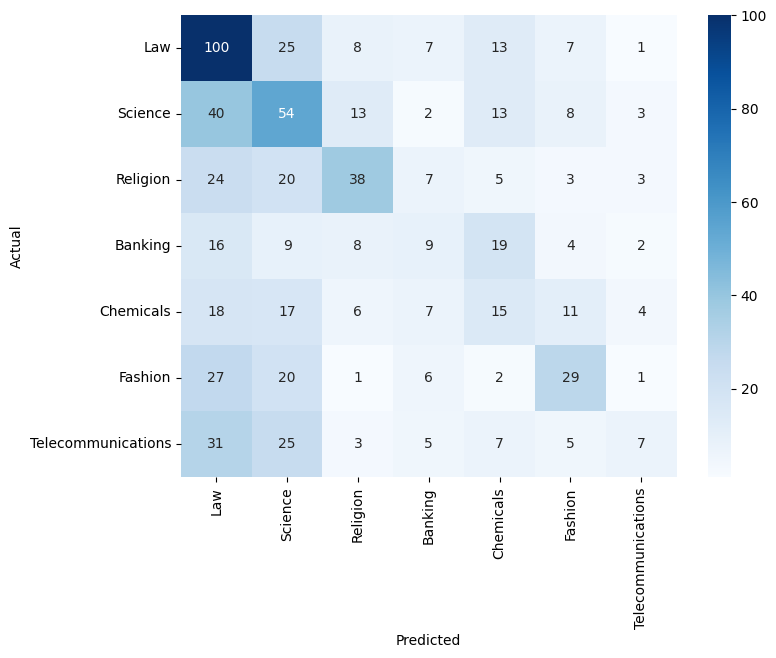

In [38]:
# Now let's plot the confusion matrix to check the miss classified predictions

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="d", xticklabels=topic_id_df.topic.values, yticklabels=topic_id_df.topic.values)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()